## The Problem Statement

I would be building a web application to help the people working in the Accounts Receivable departments in their day-to-day activities. In the webapp, the users would be able to view the invoice date from various buyers and see various fields of the invoices from them.

For this, we would:
- Perform Data Pre-processing on the invoice data
- Get account-level analytics to easily visualize and interpret data with EDA and
Feature Engineering
- Get a prediction of when the invoice is going to get paid.

---

### Machine Learning Project Checklist:
1. Framing the Problem
2. Data Loading and Preprocessing
3. Exploratory Data Analysis
4. Feature Engineering and Feature Selection
5. Modelling the Data
6. Finetuning the Model
7. Presenting the Solution


# Framing the Problem
We are given a dataset of 50k records and several columns with which we have to predict the delay between due date and payment date. This is a Regression problem to predict the continuous variable of Delay, and we would be solving this though through tradition Machine Learning modeling techniques.

# 1. Loading in our Data

## Loading Dependencies

In [2]:
# installing packages
!pip install xgboost lightgbm catboost optuna --q

In [3]:
# for handling numerical data
import pandas as pd
import numpy as np
from datetime import datetime

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# for building models
import optuna
import xgboost as xgb
import lightgbm as lgbm
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool

# for validating models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# miscellaneous
import warnings

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

## Loading and Understanding our Data

In [4]:
# loading given dataset
df = pd.read_csv('dataset.csv')

### Exploring the Dataset

In [5]:
df.sample(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
2328,U001,0200762301,C&S WH co,2019-05-14 00:00:00,2019.0,1.929224e+09,2019-04-29,20190429,20190429,20190514.0,USD,RV,1.0,NaN,67126.62,20190429.0,NAC6,1.929224e+09,0
30512,U001,0200763814,SYSCO F llc,2019-04-29 00:00:00,2019.0,1.929131e+09,2019-04-11,20190411,20190411,20190426.0,USD,RV,1.0,NaN,24912.79,20190411.0,NAA8,1.929131e+09,0
25389,U001,0200769623,WAL-MAR in,2019-04-02 00:00:00,2019.0,1.929010e+09,2019-03-22,20190322,20190322,20190406.0,USD,RV,1.0,NaN,50098.07,20190322.0,NAH4,1.929010e+09,0
35710,U001,0200779719,FOOD 4 foundation,2019-06-07 00:00:00,2019.0,1.929359e+09,2019-05-23,20190522,20190523,20190607.0,USD,RV,1.0,NaN,19436.32,20190523.0,NAA8,1.929359e+09,0
8974,U001,0200769623,WAL-MAR us,2019-08-14 00:00:00,2019.0,1.929699e+09,2019-08-03,20190803,20190803,20190818.0,USD,RV,1.0,NaN,9620.25,20190803.0,NAH4,1.929699e+09,0


We have the description for each of the columns here:
- `business_code`: company code of the account
- `cust_number`: customer number given to all the customers of the account
- `name_customer`: name of the customer
- `clear_date`: date on which the customer clears an invoice, or in simple terms, makes the full payment **IMP**
- `business_year`: the year in which the invoice was created
- `doc_id`: a unique identifier of an invoice
- `posting_date`: the date on which the particular invoice was entered in the ERP database **IMP**
- `document_create_date`: the date on which the invoice document was created **IMP**
- `document_create_date.1`: normalized version of document_create_date (we'll use this to split the data) **this .1 is probably more important than the previous two**
- `due_in_date`: the date on which the customer is expected to clear an invoice **IMP**
- `invoice_currency`: the currency of the invoice amount in the document of the invoice
- `document type`: represents the type of document, eg, D1 represents invoice
- `posting_id`: key indicator to identify whether on AR terms is invoice, deduction, credit memo based on its value. Applicable for SAP ERP
- `area_business`: business area in sap is defined as an organisational area within the financial accounting module
- `total_open_amount`: the amount that is yet to be paid for that invoice **IMP**
- `baseline_create_date`: the date on which the invoice was created **IMP**
- `cust_payment_terms`: business terms and agreements between customers and accounts on discounts and days of payments
- `invoice_id`: unique number assigned when a seller creates an invoice
- `isOpen`: indicator of whether an invoice is open or closed. isOpen = 1, means that the invoice is still open **IMP**


In [6]:
df.shape

(50000, 19)

We have 50k rows with 19 columns in total.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

From the above, we can see that almost all the columns have non-null values with a few exceptions:
1. There are 10,000 rows with `clear_date` as null. This could mean payments for 20% of the orders were not cleared. This is our unlabelled test set. 
2. There's zero values in `area_business`; likely due to not filling out of this data for any of the orders. We can drop this column.

In [8]:
# null value check
df.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    6
isOpen                        0
dtype: int64

In [9]:
# descriptive statistics check
df.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999400e+04,50000.000000
mean,2019.305700,2.012238e+09,2.019351e+07,2.019354e+07,2.019368e+07,1.0,NaN,32337.021651,2.019354e+07,2.011340e+09,0.200000
std,0.460708,2.885235e+08,4.496041e+03,4.482134e+03,4.470614e+03,0.0,NaN,39205.975231,4.482701e+03,2.766335e+08,0.400004
min,2019.000000,1.928502e+09,2.018123e+07,2.018123e+07,2.018122e+07,1.0,NaN,0.720000,2.018121e+07,1.928502e+09,0.000000
25%,2019.000000,1.929342e+09,2.019050e+07,2.019051e+07,2.019052e+07,1.0,NaN,4928.312500,2.019050e+07,1.929342e+09,0.000000
50%,2019.000000,1.929964e+09,2.019091e+07,2.019091e+07,2.019093e+07,1.0,NaN,17609.010000,2.019091e+07,1.929964e+09,0.000000
75%,2020.000000,1.930619e+09,2.020013e+07,2.020013e+07,2.020022e+07,1.0,NaN,47133.635000,2.020013e+07,1.930619e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020071e+07,1.0,NaN,668593.360000,2.020052e+07,2.960636e+09,1.000000


We note that we have data of two years from 2019 to 2020, which might be useful to detect trends later on.

# 2. Data Preprocesing

## Dropping and Renaming columns

In [10]:
# dropping null col
df.drop('area_business', axis=1, inplace=True)

In [11]:
df.shape

(50000, 18)

In [12]:
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [13]:
# renaming columns for consistency
df.rename({'buisness_year': 'business_year', 'document type': 'document_type', 'document_create_date.1': 'document_create_date_norm'}, axis=1, inplace=True)

In [14]:
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'business_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date_norm', 'due_in_date', 'invoice_currency',
       'document_type', 'posting_id', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

## Inspecting values in each Column

In [15]:
# inspecting business_code col. no changes needed
print(df['business_code'].dtype)
df['business_code'].value_counts()

object


U001    45359
CA02     3917
U013      573
U002      135
U005       11
U007        5
Name: business_code, dtype: int64

In [16]:
# inspecting cust_number col. no changes needed
print(df['cust_number'].dtype)
df['cust_number'].value_counts()

object


0200769623    11483
0200726979     1885
0200762301     1557
0200759878     1395
0200794332     1142
              ...  
0140105192        1
0200389625        1
0100043880        1
0140103413        1
200274078         1
Name: cust_number, Length: 1425, dtype: int64

In [17]:
# inspecting name_customer col. no changes needed
print(df['name_customer'].dtype)
df['name_customer'].value_counts()

object


WAL-MAR trust         1179
WAL-MAR in            1150
WAL-MAR corp          1136
WAL-MAR               1135
WAL-MAR llc           1123
                      ... 
MC A in                  1
BRADY llc                1
ESSEX  corporation       1
W H foundation           1
KAGO systems             1
Name: name_customer, Length: 4197, dtype: int64

In [18]:
# inspecting clear_date col
print(df['clear_date'].dtype)
df['clear_date'].value_counts()

object


2019-11-12 00:00:00    309
2019-09-03 00:00:00    249
2019-10-15 00:00:00    246
2019-11-01 00:00:00    242
2019-02-19 00:00:00    241
                      ... 
2020-02-16 00:00:00      1
2019-08-31 00:00:00      1
2020-01-06 00:00:00      1
2020-02-29 00:00:00      1
2019-07-20 00:00:00      1
Name: clear_date, Length: 403, dtype: int64

In [19]:
# converting clear_date to datetime
df['clear_date'] = pd.to_datetime(df['clear_date'], format='%Y-%m-%d %H:%M:%S')
df.loc[:1, 'clear_date']

0   2020-02-11
1   2019-08-08
Name: clear_date, dtype: datetime64[ns]

In [20]:
# inspecting business_year col
print(df['business_year'].dtype)
df['business_year'].value_counts()

float64


2019.0    34715
2020.0    15285
Name: business_year, dtype: int64

In [21]:
# changing business_year to int type
df = df.astype({"business_year": int})

In [22]:
# inspecting doc_id col. no changes needed
print(df['doc_id'].dtype)
df['doc_id'].value_counts()
# all unique values, possibly no importance

float64


1.930833e+09    3
1.930730e+09    3
1.929726e+09    3
1.930730e+09    3
1.930392e+09    3
               ..
1.930559e+09    1
1.930711e+09    1
1.928711e+09    1
1.929248e+09    1
1.928576e+09    1
Name: doc_id, Length: 48839, dtype: int64

In [23]:
# inspecting posting_date col
print(df['posting_date'].dtype)
df['posting_date'].value_counts()

object


2020-03-24    226
2020-03-25    218
2020-04-01    201
2020-03-27    198
2020-03-23    186
             ... 
2020-05-19      1
2020-05-17      1
2020-05-14      1
2019-12-23      1
2020-05-18      1
Name: posting_date, Length: 506, dtype: int64

In [24]:
# converting posting_date to datetime
df['posting_date'] = pd.to_datetime(df['posting_date'], format='%Y-%m-%d')
df.loc[:1, 'posting_date']

0   2020-01-26
1   2019-07-22
Name: posting_date, dtype: datetime64[ns]

In [25]:
# inspecting document_create_date col
print(df['document_create_date'].dtype)
df['document_create_date'].value_counts()

int64


20200324    229
20200325    198
20200328    196
20200401    186
20200317    186
           ... 
20200515      1
20200514      1
20181228      1
20191222      1
20200516      1
Name: document_create_date, Length: 507, dtype: int64

In [26]:
# converting document_create_date to datetime
df['document_create_date'] = pd.to_datetime(df['document_create_date'], format='%Y%m%d')
df.loc[:1, 'document_create_date']

0   2020-01-25
1   2019-07-22
Name: document_create_date, dtype: datetime64[ns]

In [27]:
# inspecting document_create_date_norm col
print(df['document_create_date_norm'].dtype)
df['document_create_date_norm'].value_counts()

int64


20200324    226
20200325    218
20200401    201
20200327    198
20200323    186
           ... 
20200519      1
20200517      1
20200514      1
20191223      1
20200518      1
Name: document_create_date_norm, Length: 506, dtype: int64

In [28]:
# converting document_create_date_norm to datetime
df['document_create_date_norm'] = pd.to_datetime(df['document_create_date_norm'], format='%Y%m%d')
df.loc[:1, 'document_create_date_norm']

0   2020-01-26
1   2019-07-22
Name: document_create_date_norm, dtype: datetime64[ns]

In [29]:
# inspecting due_in_date col
print(df['due_in_date'].dtype)
df['due_in_date'].value_counts()

float64


20200408.0    257
20200409.0    212
20200411.0    208
20200424.0    196
20200416.0    191
             ... 
20200704.0      1
20200622.0      1
20200708.0      1
20181230.0      1
20200623.0      1
Name: due_in_date, Length: 547, dtype: int64

In [30]:
# converting due_in_date to datetime
df['due_in_date'] = pd.to_datetime(df['due_in_date'].astype(int).astype(str), format='%Y%m%d')
df.loc[:1, 'due_in_date']

0   2020-02-10
1   2019-08-11
Name: due_in_date, dtype: datetime64[ns]

In [31]:
# inspecting invoice_currency col. no changes needed
print(df['invoice_currency'].dtype)
df['invoice_currency'].value_counts()

object


USD    46081
CAD     3919
Name: invoice_currency, dtype: int64

In [32]:
# inspecting document_type col. no changes needed
print(df['document_type'].dtype)
df['document_type'].value_counts()

object


RV    49994
X2        6
Name: document_type, dtype: int64

In [33]:
# inspecting posting_id col
print(df['posting_id'].dtype)
df['posting_id'].value_counts()

float64


1.0    50000
Name: posting_id, dtype: int64

In [34]:
# dropping constant value column
df.drop('posting_id', axis=1, inplace=True)
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'business_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date_norm', 'due_in_date', 'invoice_currency',
       'document_type', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [35]:
# inspecting total_open_amount col. no changes needed
print(df['total_open_amount'].dtype)
df['total_open_amount'].value_counts()

float64


1897.50     103
1898.20      98
471.56       97
943.12       66
1328.25      59
           ... 
18542.20      1
3264.82       1
90889.75      1
18931.83      1
1790.30       1
Name: total_open_amount, Length: 44349, dtype: int64

In [36]:
# inspecting baseline_create_date col
print(df['baseline_create_date'].dtype)
df['baseline_create_date'].value_counts()

float64


20200401.0    278
20200316.0    256
20200501.0    225
20200325.0    210
20190501.0    209
             ... 
20200522.0      1
20200517.0      1
20191227.0      1
20191224.0      1
20200518.0      1
Name: baseline_create_date, Length: 506, dtype: int64

In [37]:
# converting baseline_create_date to datetime
df['baseline_create_date'] = pd.to_datetime(df['baseline_create_date'].astype(int).astype(str), format='%Y%m%d')
df.loc[:1, 'baseline_create_date']

0   2020-01-26
1   2019-07-22
Name: baseline_create_date, dtype: datetime64[ns]

In [38]:
# inspecting cust_payment_terms col. no changes needed
print(df['cust_payment_terms'].dtype)
df['cust_payment_terms'].value_counts()

object


NAA8    20118
NAH4    13585
CA10     3800
NAC6     1743
NAM4     1385
        ...  
NATU        1
NAUY        1
C129        1
NATV        1
MC15        1
Name: cust_payment_terms, Length: 74, dtype: int64

In [39]:
# inspecting invoice_id col. no changes needed
print(df['invoice_id'].dtype)
df['invoice_id'].value_counts()
# all unique values, like doc_id, might drop later

float64


1.930604e+09    3
1.928709e+09    3
2.960633e+09    3
1.930730e+09    3
1.930476e+09    3
               ..
1.929854e+09    1
1.930559e+09    1
1.930711e+09    1
1.928711e+09    1
1.928576e+09    1
Name: invoice_id, Length: 48833, dtype: int64

In [40]:
# inspecting isOpen col. no changes needed
print(df['isOpen'].dtype)
df['isOpen'].value_counts()
# 0 for labeled (close date incl), 1 for unlabeled (no close date)

int64


0    40000
1    10000
Name: isOpen, dtype: int64

After dropping and formatting a few columns, we have the following DF:

In [41]:
df

,business_code,cust_number,name_customer,clear_date,business_year,doc_id,posting_date,document_create_date,document_create_date_norm,due_in_date,invoice_currency,document_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020,1.930438e+09,2020-01-26,2020-01-25,2020-01-26,2020-02-10,USD,RV,54273.28,2020-01-26,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08,2019,1.929646e+09,2019-07-22,2019-07-22,2019-07-22,2019-08-11,USD,RV,79656.60,2019-07-22,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30,2019,1.929874e+09,2019-09-14,2019-09-14,2019-09-14,2019-09-29,USD,RV,2253.86,2019-09-14,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaT,2020,2.960623e+09,2020-03-30,2020-03-30,2020-03-30,2020-04-10,CAD,RV,3299.70,2020-03-31,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019,1.930148e+09,2019-11-13,2019-11-13,2019-11-13,2019-11-28,USD,RV,33133.29,2019-11-13,NAH4,1.930148e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,U001,0200561861,CO corporation,NaT,2020,1.930797e+09,2020-04-21,2020-04-17,2020-04-21,2020-05-06,USD,RV,3187.86,2020-04-21,NAA8,1.930797e+09,1
49996,U001,0200769623,WAL-MAR co,2019-09-03,2019,1.929744e+09,2019-08-15,2019-08-14,2019-08-15,2019-08-30,USD,RV,6766.54,2019-08-15,NAH4,1.929744e+09,0
49997,U001,0200772595,SAFEW associates,2020-03-05,2020,1.930537e+09,2020-02-19,2020-02-18,2020-02-19,2020-03-05,USD,RV,6120.86,2020-02-19,NAA8,1.930537e+09,0
49998,U001,0200726979,BJ'S llc,2019-12-12,2019,1.930199e+09,2019-11-27,2019-11-26,2019-11-27,2019-12-12,USD,RV,63.48,2019-11-27,NAA8,1.930199e+09,0


## Exploring Datetime features

In [42]:
# displaying all datetime columns
df.loc[:, ['clear_date', 'business_year', 'posting_date', 'document_create_date', 'document_create_date_norm', 'due_in_date', 'baseline_create_date']]

,clear_date,business_year,posting_date,document_create_date,document_create_date_norm,due_in_date,baseline_create_date
0,2020-02-11,2020,2020-01-26,2020-01-25,2020-01-26,2020-02-10,2020-01-26
1,2019-08-08,2019,2019-07-22,2019-07-22,2019-07-22,2019-08-11,2019-07-22
2,2019-12-30,2019,2019-09-14,2019-09-14,2019-09-14,2019-09-29,2019-09-14
3,NaT,2020,2020-03-30,2020-03-30,2020-03-30,2020-04-10,2020-03-31
4,2019-11-25,2019,2019-11-13,2019-11-13,2019-11-13,2019-11-28,2019-11-13
...,...,...,...,...,...,...,...
49995,NaT,2020,2020-04-21,2020-04-17,2020-04-21,2020-05-06,2020-04-21
49996,2019-09-03,2019,2019-08-15,2019-08-14,2019-08-15,2019-08-30,2019-08-15
49997,2020-03-05,2020,2020-02-19,2020-02-18,2020-02-19,2020-03-05,2020-02-19
49998,2019-12-12,2019,2019-11-27,2019-11-26,2019-11-27,2019-12-12,2019-11-27


We will work with the normalized version of create_date which is `document_create_date_name` columnn and get rid of the columns representing almost the same values.

In [43]:
# dropping similar create cols
df.drop(['document_create_date', 'posting_date', 'baseline_create_date'], axis=1, inplace=True)

In [44]:
# renaming the only create_date col we will use
df.rename({'document_create_date_norm': 'create_date'}, axis=1, inplace=True)

In [45]:
# removing redundant columns
df.drop(['doc_id', 'invoice_id', 'isOpen'], axis=1, inplace=True)

In [46]:
# getting the #columns after preprocessing
df.shape

(50000, 11)

In [47]:
df.sample(5)

,business_code,cust_number,name_customer,clear_date,business_year,create_date,due_in_date,invoice_currency,document_type,total_open_amount,cust_payment_terms
3850,U001,0200418007,AM llc,2020-02-26,2020,2020-02-11,2020-02-26,USD,RV,274.20,NAA8
39513,U001,0200759878,SA corp,2019-12-27,2019,2019-12-05,2019-12-20,USD,RV,16898.45,NAH4
6459,U001,0200712102,SUGAR trust,2019-07-01,2019,2019-04-24,2019-06-23,USD,RV,71842.97,NAVQ
47662,U001,0200705742,DOT,2020-01-27,2020,2020-01-07,2020-02-08,USD,RV,72494.84,NA32
47460,U001,0200759878,SA corp,2019-06-18,2019,2019-06-02,2019-06-17,USD,RV,55282.87,NAH4


## Splitting the DF into Labeled and Unlabeled Target

For further analysis and feature engineering, we will only be working with the labeled data. Hence, we need to split them up.

In [48]:
# splitting unlabelled data
not_cleared_filt = df['clear_date'].isna()
unlabeled_df = df.loc[not_cleared_filt]
unlabeled_df.shape

(10000, 11)

In [49]:
# filtering labelled data for our train-test-val split
cleared_filt = df['clear_date'].notna()
labeled_df = df.loc[cleared_filt]
labeled_df.shape

(40000, 11)

# 3. Exploratory Data Analysis

In [50]:
labeled_df.sample(5)

,business_code,cust_number,name_customer,clear_date,business_year,create_date,due_in_date,invoice_currency,document_type,total_open_amount,cust_payment_terms
21042,U001,0200774000,RALEY associates,2019-08-13,2019,2019-07-29,2019-08-13,USD,RV,36167.92,NAA8
16126,U001,0200769623,WAL-MAR trust,2019-09-10,2019,2019-08-29,2019-09-13,USD,RV,52949.50,NAH4
44712,U001,CCU002,KRFT FDS in,2019-08-30,2019,2019-07-10,2019-08-14,USD,RV,25778.48,NAG2
14335,U001,200895843,US llc,2019-07-08,2019,2019-06-19,2019-07-04,USD,RV,53787.05,NAA8
49819,U001,0200772670,ASSOCIAT,2019-10-03,2019,2019-09-16,2019-10-01,USD,RV,95711.60,NAU5


## Getting the Delay in Payment

In [51]:
# creating delay timedelta col
warnings.filterwarnings('ignore')
labeled_df.loc[:, 'delay_days'] = (labeled_df['clear_date'] - labeled_df['due_in_date']).dt.days
labeled_df['delay_days'].head(5)

0     1
1    -3
2    92
4    -3
5    61
Name: delay_days, dtype: int64

In [52]:
labeled_df['delay_days'].value_counts()

 0      8450
 1      4794
 2      3890
-5      3037
-4      2835
        ... 
-71        1
 204       1
 115       1
 171       1
-79        1
Name: delay_days, Length: 176, dtype: int64

In [53]:
labeled_df.loc[0,'delay_days']

1

## Understanding the Variables

In [54]:
labeled_df.sample(5)

,business_code,cust_number,name_customer,clear_date,business_year,create_date,due_in_date,invoice_currency,document_type,total_open_amount,cust_payment_terms,delay_days
23009,U001,0200718130,SYSCO F co,2019-02-08,2019,2019-01-24,2019-02-08,USD,RV,67505.61,NAA8,0
29063,U001,0200418007,AM systems,2019-04-15,2019,2019-03-30,2019-04-14,USD,RV,129857.32,NAA8,1
16308,CA02,0140106184,JAM llc,2019-08-01,2019,2019-07-19,2019-08-01,CAD,RV,3698.20,CA10,0
12320,U001,0200589514,TONY llc,2019-10-23,2019,2019-10-03,2019-10-18,USD,RV,130205.84,NAA8,5
25377,CA02,0140106181,THE co,2019-06-25,2019,2019-02-15,2019-02-25,CAD,RV,24791.57,CA10,120


In [55]:
# getting #unique values for all columns
labeled_df.nunique(axis=0)

business_code             6
cust_number            1344
name_customer          3889
clear_date              403
business_year             2
create_date             424
due_in_date             491
invoice_currency          2
document_type             2
total_open_amount     35664
cust_payment_terms       70
delay_days              176
dtype: int64

In [56]:
# observing the descriptive statistics without the scientific notation
labeled_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,business_year,total_open_amount,delay_days
count,40000.000000,40000.000000,40000.000000
mean,2019.132125,32065.034894,0.837700
std,0.338631,39531.091198,10.831701
min,2019.000000,0.790000,-89.000000
25%,2019.000000,4702.532500,-3.000000
50%,2019.000000,17283.500000,0.000000
75%,2019.000000,46543.025000,2.000000
max,2020.000000,668593.360000,204.000000


- The maximum delay is 204 days while the minimum delay is -89 days with 50% of the delay being between -3 and 2 days.
- Total amount has a maximum value of about 650k USD which might be an outlier
- At least 75% of the dates are from 2019

In [57]:
# doing null check
labeled_df.isna().sum()

business_code         0
cust_number           0
name_customer         0
clear_date            0
business_year         0
create_date           0
due_in_date           0
invoice_currency      0
document_type         0
total_open_amount     0
cust_payment_terms    0
delay_days            0
dtype: int64

## Outlier Detection

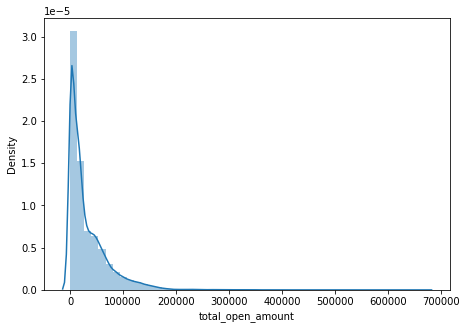

In [58]:
# plotting the amount column
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(labeled_df['total_open_amount'])
plt.show()

We see that total_open_amount is an extremely skewed distribution and the tail extends up to almost 700,000. We will investigate this with IQR.

<AxesSubplot:xlabel='total_open_amount'>

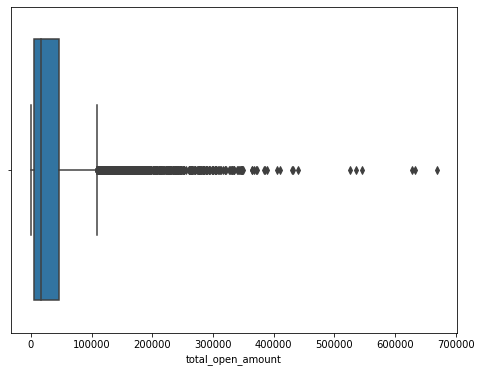

In [59]:
# forming a box-plot for the skewed feature
sns.boxplot(labeled_df['total_open_amount'])

In [60]:
# finding the IQR
percentile25 = labeled_df['total_open_amount'].quantile(0.25)
percentile90 = labeled_df['total_open_amount'].quantile(0.90)

In [61]:
percentile90

81762.62399999998

In [62]:
filt = labeled_df['total_open_amount'] > 81000
labeled_df.loc[filt].shape

(4072, 12)

We will NOT be removing the outliers for the following reasons:
- the results are critical: the payment amount may be directly related to the delay in invoice payment
- there are a lot of outliers: this means that it's not just an irregularity and there might be something interesting here

## Analyzing Possible Relationships

We can use a Correlation Matrix to get a general understanding of our dataset.

<AxesSubplot:>

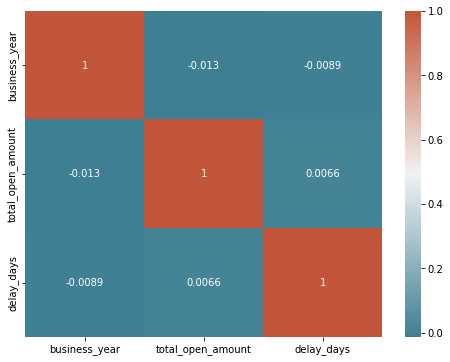

In [63]:
# calculate correlation matrix
corr = labeled_df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

We don't get much information from this since much of our data is still in a categorical format which we will convert later on. We will come back to this after Feature Engineering.

<AxesSubplot:xlabel='clear_date', ylabel='total_open_amount'>

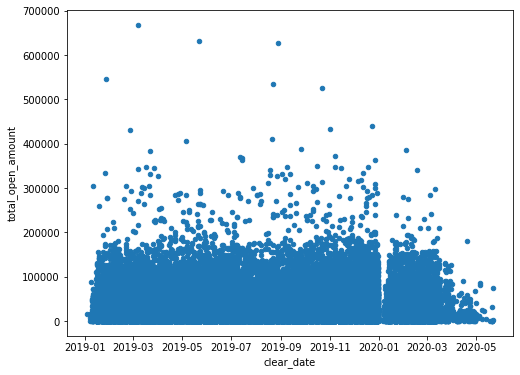

In [64]:
labeled_df.plot(kind='scatter', x='clear_date', y='total_open_amount')

Much of the payments are below the order amount of 200k USD.

<AxesSubplot:xlabel='delay_days', ylabel='total_open_amount'>

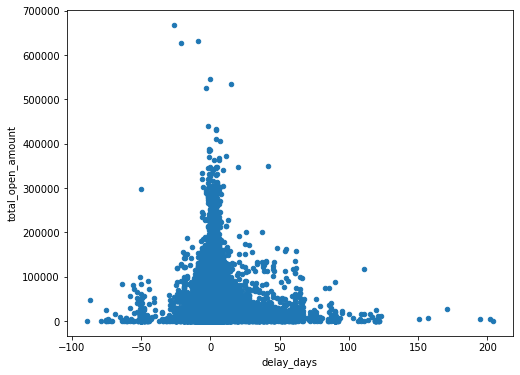

In [65]:
labeled_df.plot(kind='scatter', x='delay_days', y='total_open_amount')

We see some relation between the amount and delay in payment.

<AxesSubplot:xlabel='delay_days', ylabel='cust_payment_terms'>

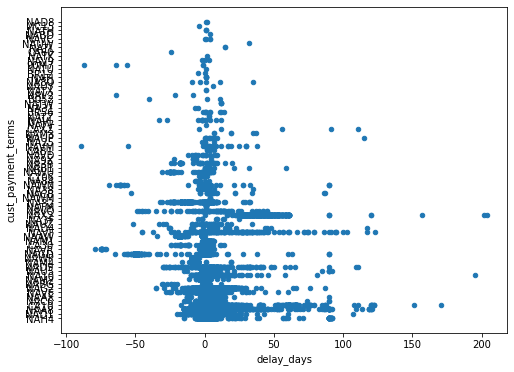

In [66]:
labeled_df.plot(kind='scatter', x='delay_days', y='cust_payment_terms')

We also see some relation between the payment terms and delay in payment.

## Time Series Analysis

In [67]:
# deep copying DF to not affect the original data
time_labeled_df = labeled_df.copy()

In [68]:
# setting invoice due date as index
time_labeled_df = time_labeled_df.set_index('due_in_date')

In [69]:
time_labeled_df.index

DatetimeIndex(['2020-02-10', '2019-08-11', '2019-09-29', '2019-11-28',
               '2019-10-04', '2019-11-16', '2019-06-22', '2019-03-07',
               '2019-01-17', '2019-04-30',
               ...
               '2019-09-25', '2020-03-04', '2019-06-06', '2019-10-25',
               '2020-01-23', '2019-07-25', '2019-08-30', '2020-03-05',
               '2019-12-12', '2019-01-24'],
              dtype='datetime64[ns]', name='due_in_date', length=40000, freq=None)

In [70]:
time_labeled_df.head()

,business_code,cust_number,name_customer,clear_date,business_year,create_date,invoice_currency,document_type,total_open_amount,cust_payment_terms,delay_days
due_in_date,,,,,,,,,,,
2020-02-10,U001,0200769623,WAL-MAR corp,2020-02-11,2020,2020-01-26,USD,RV,54273.28,NAH4,1
2019-08-11,U001,0200980828,BEN E,2019-08-08,2019,2019-07-22,USD,RV,79656.60,NAD1,-3
2019-09-29,U001,0200792734,MDV/ trust,2019-12-30,2019,2019-09-14,USD,RV,2253.86,NAA8,92
2019-11-28,U001,0200769623,WAL-MAR foundation,2019-11-25,2019,2019-11-13,USD,RV,33133.29,NAH4,-3
2019-10-04,CA02,0140106181,THE corporation,2019-12-04,2019,2019-09-20,CAD,RV,22225.84,CA10,61


In [71]:
# viewing 2019
time_labeled_df.loc['2019']

,business_code,cust_number,name_customer,clear_date,business_year,create_date,invoice_currency,document_type,total_open_amount,cust_payment_terms,delay_days
due_in_date,,,,,,,,,,,
2019-08-11,U001,0200980828,BEN E,2019-08-08,2019,2019-07-22,USD,RV,79656.60,NAD1,-3
2019-09-29,U001,0200792734,MDV/ trust,2019-12-30,2019,2019-09-14,USD,RV,2253.86,NAA8,92
2019-11-28,U001,0200769623,WAL-MAR foundation,2019-11-25,2019,2019-11-13,USD,RV,33133.29,NAH4,-3
2019-10-04,CA02,0140106181,THE corporation,2019-12-04,2019,2019-09-20,CAD,RV,22225.84,CA10,61
2019-11-16,U001,0200769623,WAL-MAR in,2019-11-12,2019,2019-11-01,USD,RV,7358.49,NAH4,-4
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-25,U001,0200704045,RA trust,2019-10-25,2019,2019-10-10,USD,RV,73002.24,NAA8,0
2019-07-25,U001,0200762301,C&S WH trust,2019-07-25,2019,2019-07-10,USD,RV,84780.40,NAC6,0
2019-08-30,U001,0200769623,WAL-MAR co,2019-09-03,2019,2019-08-15,USD,RV,6766.54,NAH4,4


In [72]:
# assigning delay 
delay_data = time_labeled_df['delay_days']
delay_data.head()

due_in_date
2020-02-10     1
2019-08-11    -3
2019-09-29    92
2019-11-28    -3
2019-10-04    61
Name: delay_days, dtype: int64

<AxesSubplot:xlabel='due_in_date'>

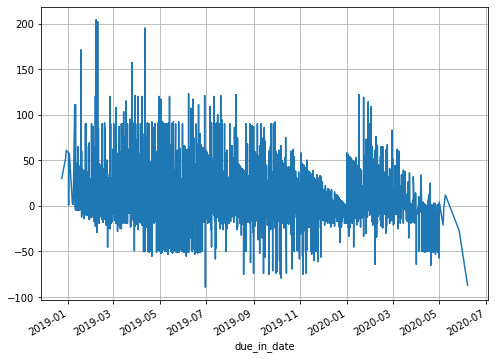

In [73]:
# plotting delay days vs the due date
delay_data.plot(grid=True)

- we can see that the delay is relatively high in the first two quarters of an year and then it gets the lowest near year end
- we also see that a major chunk of the delays are between -50 and 50 days
- multiple charts for multiple years is not possible since only 1.5 years of data is available

array([<AxesSubplot:xlabel='due_in_date'>,
       <AxesSubplot:xlabel='due_in_date'>], dtype=object)

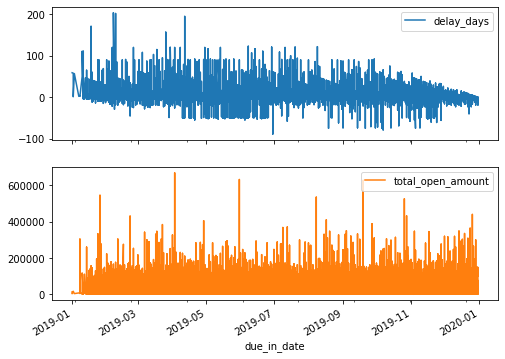

In [74]:
# checking if there's any relation between order amount and delay time
warnings.filterwarnings('ignore')
label_df_2019 = time_labeled_df['2019']
delay_data_2019 = label_df_2019.loc[:, ['delay_days', 'total_open_amount']]
delay_data_2019.plot(subplots=True)

<AxesSubplot:>

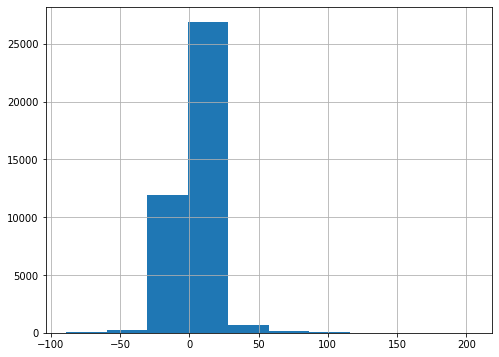

In [75]:
# histogram for delay time
delay_data.hist()

array([[<AxesSubplot:title={'center':'clear_date'}>,
        <AxesSubplot:title={'center':'business_year'}>]], dtype=object)

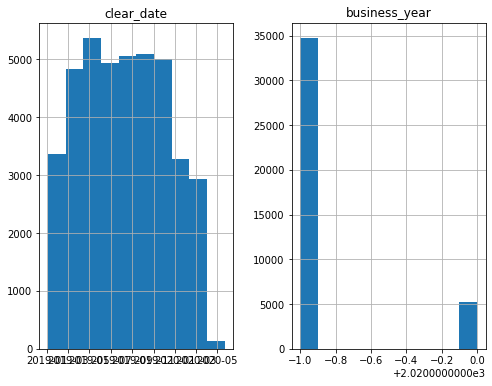

In [76]:
# histograms of all col except delay
time_labeled_df[['business_code', 'cust_number', 'name_customer', 'clear_date', 'business_year', 'invoice_currency']].hist()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 24)'>

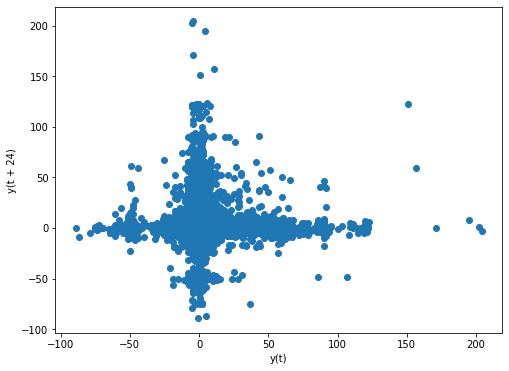

In [77]:
# lag plot with lag of 1 day. check autocorrelation
pd.plotting.lag_plot(time_labeled_df['delay_days'], lag=24)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 4320)'>

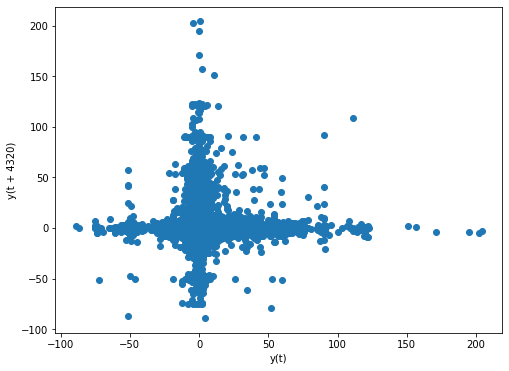

In [78]:
# lag plot with lag of 6 months
pd.plotting.lag_plot(time_labeled_df['delay_days'], lag=4320)

array([<AxesSubplot:xlabel='due_in_date'>,
       <AxesSubplot:xlabel='due_in_date'>,
       <AxesSubplot:xlabel='due_in_date'>,
       <AxesSubplot:xlabel='due_in_date'>], dtype=object)

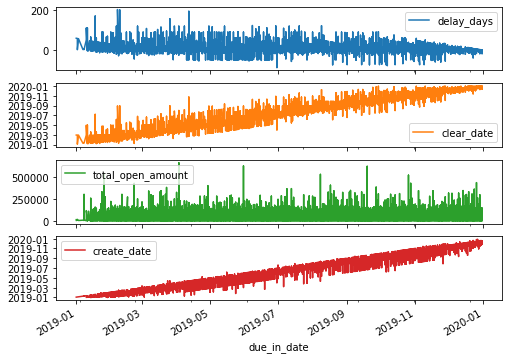

In [79]:
# multivariate check
label_df_2019 = time_labeled_df['2019']
delay_data_2019 = label_df_2019[['delay_days', 'business_code', 'cust_number', 'name_customer', 'clear_date', 'invoice_currency', 'document_type', 'total_open_amount', 'cust_payment_terms', 'create_date']]
delay_data_2019.plot(subplots=True)

We see that both the dates follow the direction as expected while delay and total amount are more or less linear.

From our analysis and visualization above, we see that there's no clear seasonality and trends between any of the relevant features of our dataset. Thus, no Time Series modeling is needed and we can go ahead with traditional Machine Learning modeling techniques in the next section.

# 4. Feature Engineering

In [80]:
# checking original DF
labeled_df.sample(5)

,business_code,cust_number,name_customer,clear_date,business_year,create_date,due_in_date,invoice_currency,document_type,total_open_amount,cust_payment_terms,delay_days
31395,U001,0200706844,WINC co,2020-01-13,2020,2019-12-29,2020-01-13,USD,RV,11549.27,NAA8,0
13146,U001,0200696090,UNITE corporation,2020-02-10,2020,2020-01-24,2020-02-08,USD,RV,3899.95,NAA8,2
10537,U001,0200793568,SUPE corp,2019-12-11,2019,2019-11-24,2019-12-09,USD,RV,47412.55,NAA8,2
43818,CA02,0140104440,SO corporation,2019-10-15,2019,2019-09-25,2019-10-11,CAD,RV,125968.72,CA10,4
19515,U001,0100058619,GREEN us,2020-03-16,2020,2020-02-10,2020-03-16,USD,RV,41373.26,NAG2,0


## Creating New Features from Datetime Variables

Splitting the create_date column.

In [81]:
# extracting date/time component
labeled_df['create_date_day'] = labeled_df['create_date'].dt.day
labeled_df['create_date_month'] = labeled_df['create_date'].dt.month
labeled_df['create_date_day_of_week'] = labeled_df['create_date'].dt.day_of_week

# creating boolean flags
labeled_df['create_date_is_quarter_start'] = labeled_df['create_date'].dt.is_quarter_start
labeled_df['create_date_is_quarter_end'] = labeled_df['create_date'].dt.is_quarter_end
labeled_df['create_date_is_month_start'] = labeled_df['create_date'].dt.is_month_start
labeled_df['create_date_is_month_end'] = labeled_df['create_date'].dt.is_month_end

Splitting the due_in_date column.

In [82]:
# extracting date/time component
labeled_df['due_in_date_day'] = labeled_df['due_in_date'].dt.day
labeled_df['due_in_date_month'] = labeled_df['due_in_date'].dt.month
labeled_df['due_in_date_day_of_week'] = labeled_df['due_in_date'].dt.day_of_week

# creating boolean flags
labeled_df['due_in_date_is_quarter_start'] = labeled_df['due_in_date'].dt.is_quarter_start
labeled_df['due_in_date_is_quarter_end'] = labeled_df['due_in_date'].dt.is_quarter_end
labeled_df['due_in_date_is_month_start'] = labeled_df['due_in_date'].dt.is_month_start
labeled_df['due_in_date_is_month_end'] = labeled_df['due_in_date'].dt.is_month_end

In [84]:
# we end up with 26 columns now
labeled_df.shape

(40000, 26)

In [85]:
pd.options.display.max_columns = 1000

In [86]:
labeled_df.sample(3)

,business_code,cust_number,name_customer,clear_date,business_year,create_date,due_in_date,invoice_currency,document_type,total_open_amount,cust_payment_terms,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end
5954,U001,0200759878,SA co,2019-03-21,2019,2019-03-05,2019-03-20,USD,RV,15113.86,NAH4,1,5,3,1,False,False,False,False,20,3,2,False,False,False,False
29185,U001,0200726979,BJ'S corp,2019-08-13,2019,2019-07-29,2019-08-13,USD,RV,339.17,NAA8,0,29,7,0,False,False,False,False,13,8,1,False,False,False,False
30825,U001,0200780825,SYSCO FO in,2019-08-21,2019,2019-08-05,2019-08-20,USD,RV,3232.16,NAA8,1,5,8,0,False,False,False,False,20,8,1,False,False,False,False


## One-Hot Encoding Categorical Variables

In [87]:
labeled_df.dtypes

business_code                           object
cust_number                             object
name_customer                           object
clear_date                      datetime64[ns]
business_year                            int32
create_date                     datetime64[ns]
due_in_date                     datetime64[ns]
invoice_currency                        object
document_type                           object
total_open_amount                      float64
cust_payment_terms                      object
delay_days                               int64
create_date_day                          int64
create_date_month                        int64
create_date_day_of_week                  int64
create_date_is_quarter_start              bool
create_date_is_quarter_end                bool
create_date_is_month_start                bool
create_date_is_month_end                  bool
due_in_date_day                          int64
due_in_date_month                        int64
due_in_date_d

In [88]:
# dropping datetime features since we have all their information extracted already
labeled_df.drop(['clear_date', 'due_in_date'], axis=1, inplace=True)

In [89]:
labeled_df.head(5)

,business_code,cust_number,name_customer,business_year,create_date,invoice_currency,document_type,total_open_amount,cust_payment_terms,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end
0,U001,0200769623,WAL-MAR corp,2020,2020-01-26,USD,RV,54273.28,NAH4,1,26,1,6,False,False,False,False,10,2,0,False,False,False,False
1,U001,0200980828,BEN E,2019,2019-07-22,USD,RV,79656.60,NAD1,-3,22,7,0,False,False,False,False,11,8,6,False,False,False,False
2,U001,0200792734,MDV/ trust,2019,2019-09-14,USD,RV,2253.86,NAA8,92,14,9,5,False,False,False,False,29,9,6,False,False,False,False
4,U001,0200769623,WAL-MAR foundation,2019,2019-11-13,USD,RV,33133.29,NAH4,-3,13,11,2,False,False,False,False,28,11,3,False,False,False,False
5,CA02,0140106181,THE corporation,2019,2019-09-20,CAD,RV,22225.84,CA10,61,20,9,4,False,False,False,False,4,10,4,False,False,False,False


We are keeping the `create_date` column for now as we will need it later on to split our data by that its order for train-test-val.

In [90]:
labeled_df['business_code'].value_counts().head(10).sum()

40000

In [91]:
labeled_df['cust_number'].value_counts().head(10).sum()

16960

In [92]:
labeled_df['name_customer'].value_counts().head(10).sum()

8765

In [93]:
labeled_df['cust_payment_terms'].value_counts().head(10).sum()

35964

**Features for Dropping:**
1. cust_number
2. name_customer
- We see that more than 50% of the data for `cust_number` and `name_customer` are outside of the top 10 categories. Thus, we can't one-hot encode this due to the curse of dimensionality. Label-encoding can't be applied as well due to how Tree Algorithms handle numerical data as ordinal data.

**Features for Formatting:**
1. invoice_currency (then drop)
2. total_open_amount
- Here, we would convert the CAD amount to USD amount and then remove `invoice_currency` col, ending up with a consistent amount column.

**Features for One-Hot Encoding:**
1. business_code
2. document_type
3. cust_payment_terms
- These categorical features can be one-hot encoded since most or all of their values is within 10 categories, preventing dimensionality concerns.



### Dropping Features

In [94]:
labeled_df.columns

Index(['business_code', 'cust_number', 'name_customer', 'business_year',
       'create_date', 'invoice_currency', 'document_type', 'total_open_amount',
       'cust_payment_terms', 'delay_days', 'create_date_day',
       'create_date_month', 'create_date_day_of_week',
       'create_date_is_quarter_start', 'create_date_is_quarter_end',
       'create_date_is_month_start', 'create_date_is_month_end',
       'due_in_date_day', 'due_in_date_month', 'due_in_date_day_of_week',
       'due_in_date_is_quarter_start', 'due_in_date_is_quarter_end',
       'due_in_date_is_month_start', 'due_in_date_is_month_end'],
      dtype='object')

Dropping the features identified above.

In [95]:
# categorical features to be dropped
labeled_df.drop(['cust_number', 'name_customer'], axis=1, inplace=True)

### Converting Features

Currency Conversion.

In [96]:
# CAD amount filter
cad_filt = labeled_df['invoice_currency'] == 'CAD'
labeled_df.loc[cad_filt, 'total_open_amount']

5         22225.84
29        48413.28
44        31715.46
61         2827.80
63         6912.00
           ...    
49851    150075.40
49879     46696.50
49889     60134.34
49926      5727.30
49955      1082.69
Name: total_open_amount, Length: 3182, dtype: float64

In [97]:
# converting CAD to USD with 2019 conversion rate
labeled_df.loc[cad_filt, 'total_open_amount'] = labeled_df.loc[cad_filt, 'total_open_amount'] * 0.75
labeled_df.loc[cad_filt, 'total_open_amount']

5         16669.3800
29        36309.9600
44        23786.5950
61         2120.8500
63         5184.0000
            ...     
49851    112556.5500
49879     35022.3750
49889     45100.7550
49926      4295.4750
49955       812.0175
Name: total_open_amount, Length: 3182, dtype: float64

In [98]:
# renaming and dropping col
labeled_df.rename({'total_open_amount': 'amount_USD'}, axis=1, inplace=True)
labeled_df.drop('invoice_currency', axis=1, inplace=True)

<AxesSubplot:>

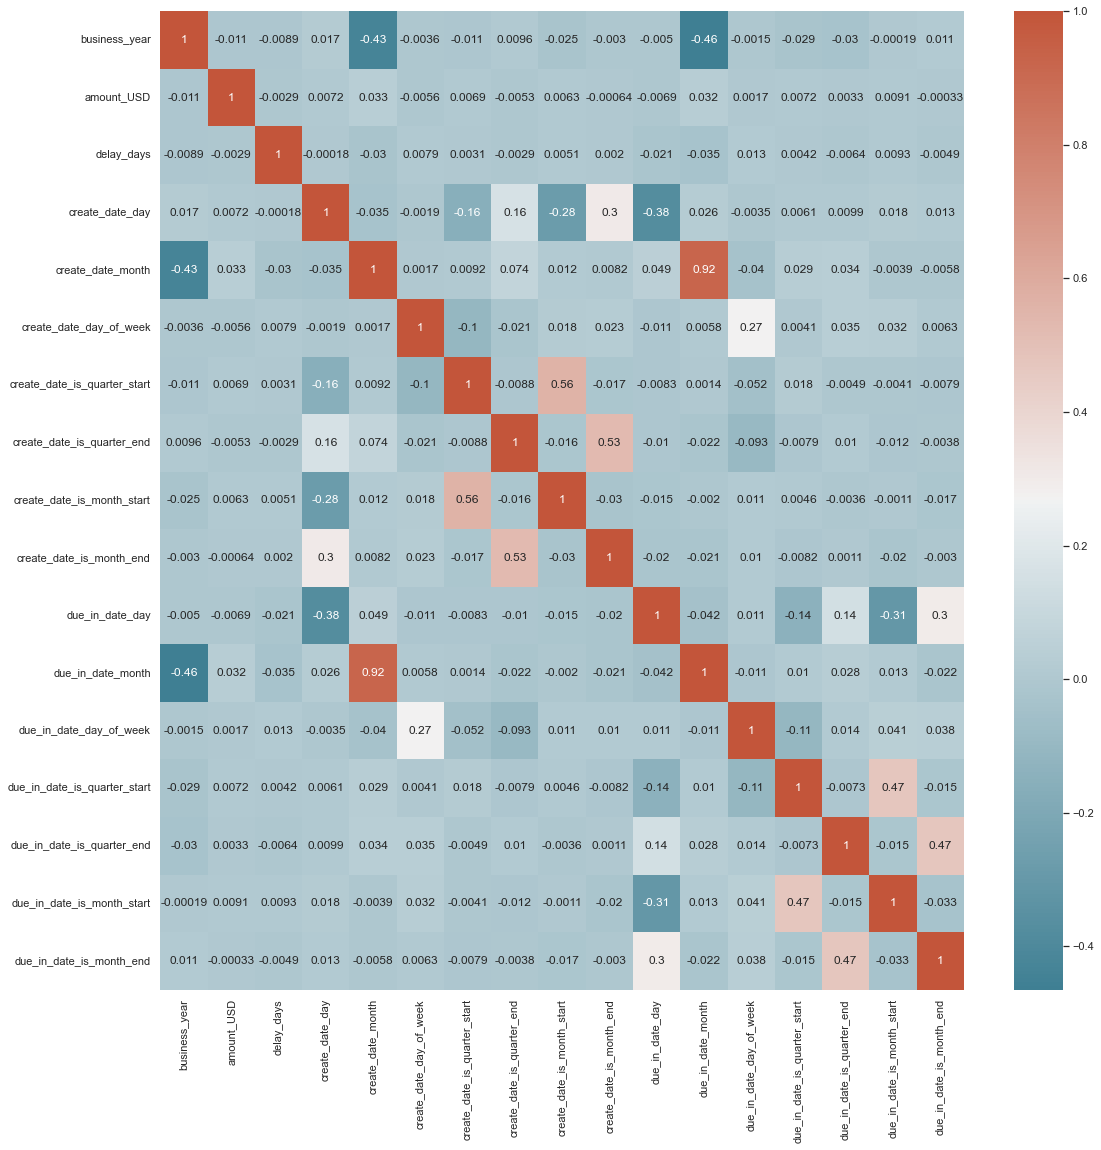

In [100]:
# calculate correlation matrix matrix

corr = labeled_df.corr() # plot the heatmap
sns.set(rc = {'figure.figsize':(18,18)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### Encoding Categorical Features

In [101]:
labeled_df.sample(3)

,business_code,business_year,create_date,document_type,amount_USD,cust_payment_terms,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end
42874,U001,2019,2019-03-20,RV,2191.95,NAD5,48,20,3,2,False,False,False,False,19,4,4,False,False,False,False
23668,CA02,2020,2020-02-14,RV,43565.07,CA10,0,14,2,4,False,False,False,False,28,2,4,False,False,False,False
14807,U001,2019,2019-06-10,RV,905.77,NAU5,8,10,6,0,False,False,False,False,25,6,1,False,False,False,False


In [102]:
# making a deep copy containing categorical features
cat_df = labeled_df.copy()

In [103]:
# we see that the top 15 variables in this col account for almost all the datapoints
labeled_df['cust_payment_terms'].value_counts().head(15).sum()

38259

In [104]:
# making lists with top 10 variables
top_15_code = [x for x in labeled_df['business_code'].value_counts().sort_values(ascending=False).head(15).index]
top_15_type = [x for x in labeled_df['document_type'].value_counts().sort_values(ascending=False).head(15).index]
top_15_terms = [x for x in labeled_df['cust_payment_terms'].value_counts().sort_values(ascending=False).head(15).index]
top_15_code, top_15_type, top_15_terms

(['U001', 'CA02', 'U013', 'U002', 'U005', 'U007'],
 ['RV', 'X2'],
 ['NAA8',
  'NAH4',
  'CA10',
  'NAC6',
  'NAM4',
  'NAAX',
  'NAD1',
  'NAG2',
  'NAU5',
  'NAGD',
  'NA32',
  'NAX2',
  'NAM2',
  'NA10',
  'NAD5'])

In [105]:
# getting all dummy variables for all categorical cols

def one_hot_top_x(df, col, top_x_labels):
    for label in top_x_labels:
        # one-hot encoding with ternary operator
        df[col+'_'+label] = np.where(df[col] == label, 1, 0)

one_hot_top_x(labeled_df, 'business_code', top_15_code)
one_hot_top_x(labeled_df, 'document_type', top_15_type)
one_hot_top_x(labeled_df, 'cust_payment_terms', top_15_terms)
labeled_df.head()

,business_code,business_year,create_date,document_type,amount_USD,cust_payment_terms,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end,business_code_U001,business_code_CA02,business_code_U013,business_code_U002,business_code_U005,business_code_U007,document_type_RV,document_type_X2,cust_payment_terms_NAA8,cust_payment_terms_NAH4,cust_payment_terms_CA10,cust_payment_terms_NAC6,cust_payment_terms_NAM4,cust_payment_terms_NAAX,cust_payment_terms_NAD1,cust_payment_terms_NAG2,cust_payment_terms_NAU5,cust_payment_terms_NAGD,cust_payment_terms_NA32,cust_payment_terms_NAX2,cust_payment_terms_NAM2,cust_payment_terms_NA10,cust_payment_terms_NAD5
0,U001,2020,2020-01-26,RV,54273.28,NAH4,1,26,1,6,False,False,False,False,10,2,0,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,U001,2019,2019-07-22,RV,79656.60,NAD1,-3,22,7,0,False,False,False,False,11,8,6,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,U001,2019,2019-09-14,RV,2253.86,NAA8,92,14,9,5,False,False,False,False,29,9,6,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,U001,2019,2019-11-13,RV,33133.29,NAH4,-3,13,11,2,False,False,False,False,28,11,3,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,CA02,2019,2019-09-20,RV,16669.38,CA10,61,20,9,4,False,False,False,False,4,10,4,False,False,False,False,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
# dropping the redundant categorical labels now
labeled_df.drop(['business_code', 'document_type', 'cust_payment_terms'], axis=1, inplace=True)

In [107]:
labeled_df.columns

Index(['business_year', 'create_date', 'amount_USD', 'delay_days',
       'create_date_day', 'create_date_month', 'create_date_day_of_week',
       'create_date_is_quarter_start', 'create_date_is_quarter_end',
       'create_date_is_month_start', 'create_date_is_month_end',
       'due_in_date_day', 'due_in_date_month', 'due_in_date_day_of_week',
       'due_in_date_is_quarter_start', 'due_in_date_is_quarter_end',
       'due_in_date_is_month_start', 'due_in_date_is_month_end',
       'business_code_U001', 'business_code_CA02', 'business_code_U013',
       'business_code_U002', 'business_code_U005', 'business_code_U007',
       'document_type_RV', 'document_type_X2', 'cust_payment_terms_NAA8',
       'cust_payment_terms_NAH4', 'cust_payment_terms_CA10',
       'cust_payment_terms_NAC6', 'cust_payment_terms_NAM4',
       'cust_payment_terms_NAAX', 'cust_payment_terms_NAD1',
       'cust_payment_terms_NAG2', 'cust_payment_terms_NAU5',
       'cust_payment_terms_NAGD', 'cust_payment_terms

In [108]:
# final numerical df
print(labeled_df.shape)
labeled_df.head()

(40000, 41)


,business_year,create_date,amount_USD,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end,business_code_U001,business_code_CA02,business_code_U013,business_code_U002,business_code_U005,business_code_U007,document_type_RV,document_type_X2,cust_payment_terms_NAA8,cust_payment_terms_NAH4,cust_payment_terms_CA10,cust_payment_terms_NAC6,cust_payment_terms_NAM4,cust_payment_terms_NAAX,cust_payment_terms_NAD1,cust_payment_terms_NAG2,cust_payment_terms_NAU5,cust_payment_terms_NAGD,cust_payment_terms_NA32,cust_payment_terms_NAX2,cust_payment_terms_NAM2,cust_payment_terms_NA10,cust_payment_terms_NAD5
0,2020,2020-01-26,54273.28,1,26,1,6,False,False,False,False,10,2,0,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019,2019-07-22,79656.60,-3,22,7,0,False,False,False,False,11,8,6,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2019,2019-09-14,2253.86,92,14,9,5,False,False,False,False,29,9,6,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019,2019-11-13,33133.29,-3,13,11,2,False,False,False,False,28,11,3,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2019,2019-09-20,16669.38,61,20,9,4,False,False,False,False,4,10,4,False,False,False,False,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
# final categorical df
print(cat_df.shape)
cat_df.head()

(40000, 21)


,business_code,business_year,create_date,document_type,amount_USD,cust_payment_terms,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end
0,U001,2020,2020-01-26,RV,54273.28,NAH4,1,26,1,6,False,False,False,False,10,2,0,False,False,False,False
1,U001,2019,2019-07-22,RV,79656.60,NAD1,-3,22,7,0,False,False,False,False,11,8,6,False,False,False,False
2,U001,2019,2019-09-14,RV,2253.86,NAA8,92,14,9,5,False,False,False,False,29,9,6,False,False,False,False
4,U001,2019,2019-11-13,RV,33133.29,NAH4,-3,13,11,2,False,False,False,False,28,11,3,False,False,False,False
5,CA02,2019,2019-09-20,RV,16669.38,CA10,61,20,9,4,False,False,False,False,4,10,4,False,False,False,False


In [110]:
# no object type features present in our encoded DF anymore
labeled_df.select_dtypes(include='O').keys()

Index([], dtype='object')

We don't need to worry about Feature Selection to a large extent since our models would handle it by themselves and assign weights according to their feature importance.

# 5. Initial Modeling

For our Modeling, we will experiment with a lot of models including Linear Regression, Boosting algorithms and Random Forests as well. After we have a baseline for each of them, we would finetune them with Optuna and select the best one at the end.

## Train-Test-Val Split

We would sort our DF by the `create` date column in ascending order so that we keep the earlier dates for training and the model predicts on future dates with the past historical data. With this, we are preventing randomization and trying to see how well it works for future unseen data.

### Splitting our Encoded DF

In [111]:
labeled_df.sample(2)

,business_year,create_date,amount_USD,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end,business_code_U001,business_code_CA02,business_code_U013,business_code_U002,business_code_U005,business_code_U007,document_type_RV,document_type_X2,cust_payment_terms_NAA8,cust_payment_terms_NAH4,cust_payment_terms_CA10,cust_payment_terms_NAC6,cust_payment_terms_NAM4,cust_payment_terms_NAAX,cust_payment_terms_NAD1,cust_payment_terms_NAG2,cust_payment_terms_NAU5,cust_payment_terms_NAGD,cust_payment_terms_NA32,cust_payment_terms_NAX2,cust_payment_terms_NAM2,cust_payment_terms_NA10,cust_payment_terms_NAD5
48724,2019,2019-10-14,19174.73,7,14,10,0,False,False,False,False,29,10,1,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
37433,2019,2019-07-03,4576.13,0,3,7,2,False,False,False,False,18,7,3,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
# sorting by create dates and then setting the index after that
labeled_df.sort_values(by='create_date', ascending=True, inplace=True)
labeled_df.reset_index(drop=True, inplace=True)
labeled_df

,business_year,create_date,amount_USD,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end,business_code_U001,business_code_CA02,business_code_U013,business_code_U002,business_code_U005,business_code_U007,document_type_RV,document_type_X2,cust_payment_terms_NAA8,cust_payment_terms_NAH4,cust_payment_terms_CA10,cust_payment_terms_NAC6,cust_payment_terms_NAM4,cust_payment_terms_NAAX,cust_payment_terms_NAD1,cust_payment_terms_NAG2,cust_payment_terms_NAU5,cust_payment_terms_NAGD,cust_payment_terms_NA32,cust_payment_terms_NAX2,cust_payment_terms_NAM2,cust_payment_terms_NA10,cust_payment_terms_NAD5
0,2019,2018-12-30,205.13,1,30,12,6,False,False,False,False,14,1,0,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019,2018-12-30,3629.22,-5,30,12,6,False,False,False,False,14,1,0,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019,2018-12-30,146.15,0,30,12,6,False,False,False,False,14,1,0,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2019,2018-12-30,110990.78,0,30,12,6,False,False,False,False,14,1,0,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019,2018-12-30,94653.07,0,30,12,6,False,False,False,False,14,1,0,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2020,2020-02-26,30576.00,-5,26,2,2,False,False,False,False,1,4,2,True,False,True,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
39996,2020,2020-02-26,553.46,0,26,2,2,False,False,False,False,12,3,3,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39997,2020,2020-02-27,49290.19,0,27,2,3,False,False,False,False,13,3,4,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
39998,2020,2020-02-27,25143.02,3,27,2,3,False,False,False,False,13,3,4,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
# generating train and test DFs on a 70-20-10 split
train_df_num = labeled_df[(labeled_df.index < np.percentile(labeled_df.index, 70))]
val_df_num = labeled_df[(labeled_df.index > np.percentile(labeled_df.index, 70)) & (labeled_df.index < np.percentile(labeled_df.index, 90))]
test_df_num = labeled_df[(labeled_df.index > np.percentile(labeled_df.index, 90))]

In [114]:
train_df_num.tail(4)

,business_year,create_date,amount_USD,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end,business_code_U001,business_code_CA02,business_code_U013,business_code_U002,business_code_U005,business_code_U007,document_type_RV,document_type_X2,cust_payment_terms_NAA8,cust_payment_terms_NAH4,cust_payment_terms_CA10,cust_payment_terms_NAC6,cust_payment_terms_NAM4,cust_payment_terms_NAAX,cust_payment_terms_NAD1,cust_payment_terms_NAG2,cust_payment_terms_NAU5,cust_payment_terms_NAGD,cust_payment_terms_NA32,cust_payment_terms_NAX2,cust_payment_terms_NAM2,cust_payment_terms_NA10,cust_payment_terms_NAD5
27996,2019,2019-10-08,4688.71,-5,8,10,1,False,False,False,False,23,10,2,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
27997,2019,2019-10-08,15691.19,-1,8,10,1,False,False,False,False,23,10,2,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
27998,2019,2019-10-08,32450.65,-5,8,10,1,False,False,False,False,23,10,2,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
27999,2019,2019-10-08,20606.01,1,8,10,1,False,False,False,False,17,11,6,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Splitting our Categorical DF

In [115]:
cat_df.sample(2)

,business_code,business_year,create_date,document_type,amount_USD,cust_payment_terms,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end
38674,U001,2020,2020-01-25,RV,12668.17,NAH4,2,25,1,5,False,False,False,False,9,2,6,False,False,False,False
45925,U001,2019,2019-02-08,RV,13340.16,NAG2,14,8,2,4,False,False,False,False,15,3,4,False,False,False,False


In [116]:

# following the above process for categorical DF
cat_df.sort_values(by='create_date', ascending=True, inplace=True)
cat_df.reset_index(drop=True, inplace=True)

# generating train and test DFs on a 70-20-10 split
train_df_cat = cat_df[(cat_df.index < np.percentile(cat_df.index, 70))]
val_df_cat = cat_df[(cat_df.index > np.percentile(cat_df.index, 70)) & (cat_df.index < np.percentile(cat_df.index, 90))]
test_df_cat = cat_df[(cat_df.index > np.percentile(cat_df.index, 90))]

In [117]:
test_df_cat.tail(4)

,business_code,business_year,create_date,document_type,amount_USD,cust_payment_terms,delay_days,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end
39996,U001,2020,2020-02-26,RV,553.46,NAA8,0,26,2,2,False,False,False,False,12,3,3,False,False,False,False
39997,U001,2020,2020-02-27,RV,49290.19,NAH4,0,27,2,3,False,False,False,False,13,3,4,False,False,False,False
39998,U001,2020,2020-02-27,RV,25143.02,NAA8,3,27,2,3,False,False,False,False,13,3,4,False,False,False,False
39999,U001,2020,2020-02-27,RV,10349.36,NAA8,6,27,2,3,False,False,False,False,13,3,4,False,False,False,False


## Declaring Feature Vector and Target Variable

### X_train, X_test, y_train, y_test for Encoded DF

In [118]:
# X split
X_train_num = train_df_num.drop(['create_date', 'delay_days'], axis=1)
X_test_num = test_df_num.drop(['create_date', 'delay_days'], axis=1)
X_val_num = val_df_num.drop(['create_date', 'delay_days'], axis=1)


# Y split
y_train_num = train_df_num['delay_days']
y_test_num = test_df_num['delay_days']
y_val_num = val_df_num['delay_days']

In [119]:
X_train_num.tail(5)

,business_year,amount_USD,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end,business_code_U001,business_code_CA02,business_code_U013,business_code_U002,business_code_U005,business_code_U007,document_type_RV,document_type_X2,cust_payment_terms_NAA8,cust_payment_terms_NAH4,cust_payment_terms_CA10,cust_payment_terms_NAC6,cust_payment_terms_NAM4,cust_payment_terms_NAAX,cust_payment_terms_NAD1,cust_payment_terms_NAG2,cust_payment_terms_NAU5,cust_payment_terms_NAGD,cust_payment_terms_NA32,cust_payment_terms_NAX2,cust_payment_terms_NAM2,cust_payment_terms_NA10,cust_payment_terms_NAD5
27995,2019,91841.57,8,10,1,False,False,False,False,23,10,2,False,False,False,False,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27996,2019,4688.71,8,10,1,False,False,False,False,23,10,2,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
27997,2019,15691.19,8,10,1,False,False,False,False,23,10,2,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
27998,2019,32450.65,8,10,1,False,False,False,False,23,10,2,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
27999,2019,20606.01,8,10,1,False,False,False,False,17,11,6,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [120]:
y_test_num.tail(5)

39995   -5
39996    0
39997    0
39998    3
39999    6
Name: delay_days, dtype: int64

In [121]:
y_val_num.tail(5)

35995     0
35996     1
35997    23
35998    -1
35999     0
Name: delay_days, dtype: int64

### X_train, X_test, y_train, y_test for Categorical DF

In [122]:
# X split
X_train_cat = train_df_cat.drop(['create_date', 'delay_days'], axis=1)
X_test_cat = test_df_cat.drop(['create_date', 'delay_days'], axis=1)
X_val_cat = val_df_cat.drop(['create_date', 'delay_days'], axis=1)


# Y split
y_train_cat = train_df_cat['delay_days']
y_test_cat = test_df_cat['delay_days']
y_val_cat = val_df_cat['delay_days']

In [123]:
X_train_cat.head(5)

,business_code,business_year,document_type,amount_USD,cust_payment_terms,create_date_day,create_date_month,create_date_day_of_week,create_date_is_quarter_start,create_date_is_quarter_end,create_date_is_month_start,create_date_is_month_end,due_in_date_day,due_in_date_month,due_in_date_day_of_week,due_in_date_is_quarter_start,due_in_date_is_quarter_end,due_in_date_is_month_start,due_in_date_is_month_end
0,U001,2019,RV,205.13,NAA8,30,12,6,False,False,False,False,14,1,0,False,False,False,False
1,U001,2019,RV,3629.22,NAH4,30,12,6,False,False,False,False,14,1,0,False,False,False,False
2,U001,2019,RV,146.15,NAU5,30,12,6,False,False,False,False,14,1,0,False,False,False,False
3,U001,2019,RV,110990.78,NAA8,30,12,6,False,False,False,False,14,1,0,False,False,False,False
4,U001,2019,RV,94653.07,NAA8,30,12,6,False,False,False,False,14,1,0,False,False,False,False


In [124]:
y_test_cat.tail(5)

39995   -5
39996    0
39997    0
39998    3
39999    6
Name: delay_days, dtype: int64

## Building Baseline Models

### Linear Regressor Baseline

A Linear Regression model takes in numerical features only so we will use our numerical DF.

In [128]:
# instantiating model
ln_reg = linear_model.LinearRegression()

In [129]:
# fit
ln_reg.fit(X_train_num,y_train_num)
# predict
preds = ln_reg.predict(X_test_num)

In [130]:
# getting regression accuracy scores
rmse = mean_squared_error(y_test_num, preds, squared=False)
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_num, preds)
print("R2: %f" % (r2))

RMSE: 8.664821
R2: 0.355955


Baseline Linear Regression gives us a RMSE of **8.66** with a R2 of **0.35**.

### XGBoost Regressor Baseline

XGBoost takes in numerical features only so we will use our numerical DF.

In [131]:
# instantiating XGB Regressor object with certain params
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 100, 
                          random_state = 42)

In [132]:
# fit
xg_reg.fit(X_train_num,y_train_num)
# predict
preds = xg_reg.predict(X_test_num)

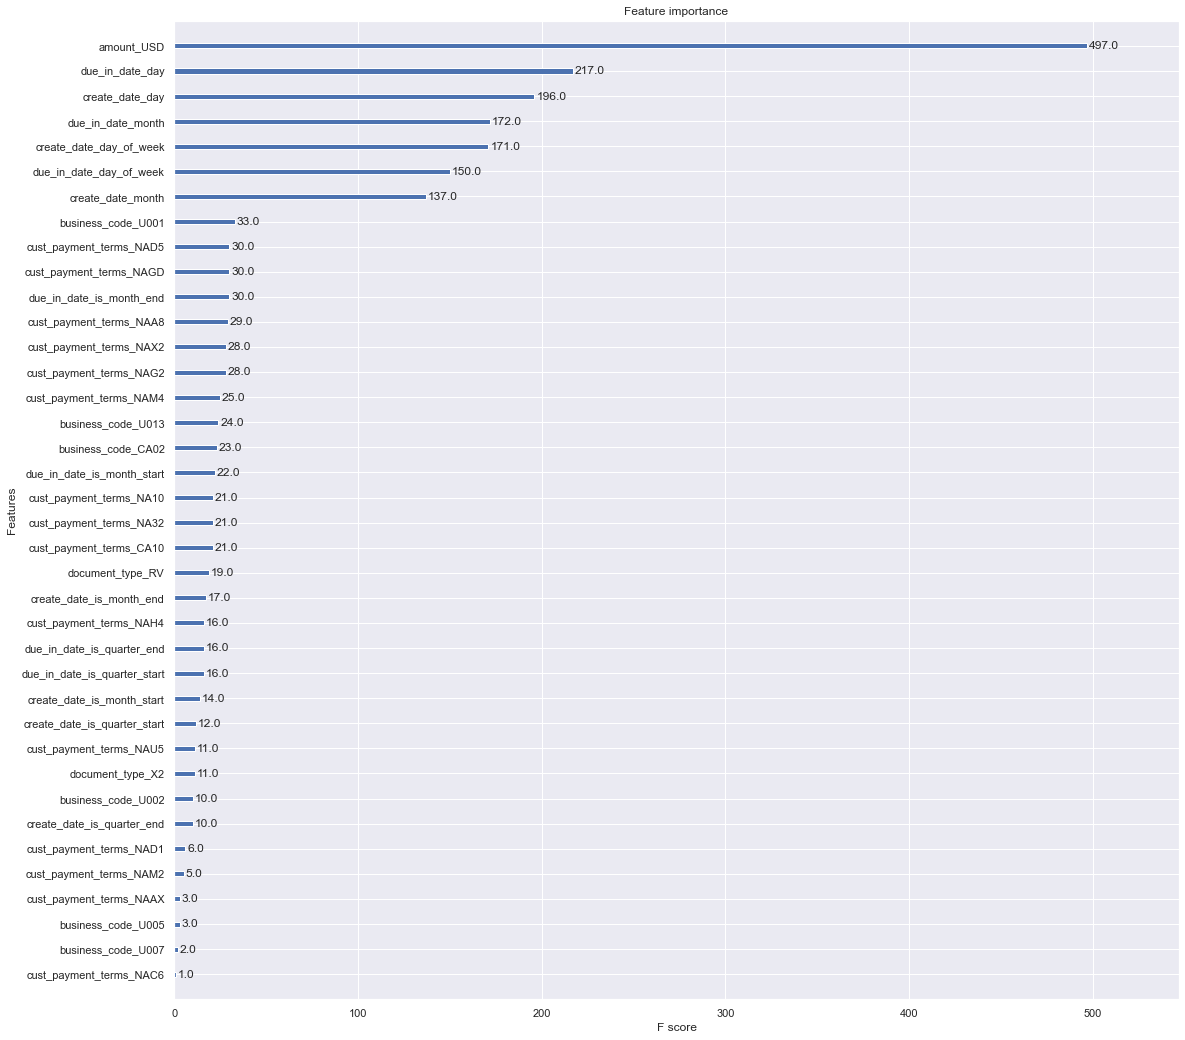

In [134]:
# Feature Importance of the Baseline Model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [133]:
# getting regression accuracy scores

rmse = np.sqrt(mean_squared_error(y_test_num, preds))
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_num, preds)
print("R2: %f" % (r2))

RMSE: 8.625703
R2: 0.361757


Baseline XGBoost Regressor gives us a RMSE of **8.62** with a R2 of **0.36**.

### LightGBM Regressor Baseline

LightGBM can handle categorical features by itself so we would use our categorical DF.

Converting all categorical features below.

In [135]:
# generating indices for cat columns
cat_features_train = X_train_cat.select_dtypes(exclude=np.number).columns.to_list()
cat_idx_train = [X_train_cat.columns.get_loc(col) for col in cat_features_train]

cat_features_val = X_val_cat.select_dtypes(exclude=np.number).columns.to_list()
cat_idx_val = [X_val_cat.columns.get_loc(col) for col in cat_features_val]

cat_features_test = X_test_cat.select_dtypes(exclude=np.number).columns.to_list()
cat_idx_test = [X_test_cat.columns.get_loc(col) for col in cat_features_test]


In [136]:
# converting cat_features to pd.Categorical dtype
for col in cat_features_train:
    X_train_cat[col] = pd.Categorical(X_train_cat[col])
    
for col in cat_features_val:
    X_val_cat[col] = pd.Categorical(X_val_cat[col])
    
for col in cat_features_test:
    X_test_cat[col] = pd.Categorical(X_test_cat[col])

In [137]:
lgbm_reg = lgbm.LGBMRegressor(
    n_estimators = 100,
    random_state = 42,
    boosting_type = 'gbdt',
    objective = 'regression',
    num_leaves = 40,
    learning_rate = 0.1,
)

In [138]:
# fit
lgbm_reg.fit(X_train_cat, y_train_cat, categorical_feature = cat_idx_train)
# predict
preds = lgbm_reg.predict(X_test_cat)

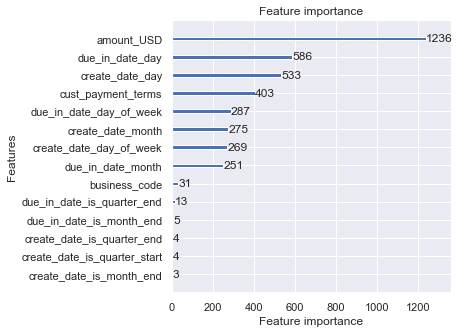

In [141]:
# Feature Importance of the Baseline Model
lgbm.plot_importance(lgbm_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [139]:
# getting regression accuracy scores
rmse = mean_squared_error(y_test_cat, preds, squared=False)
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_cat, preds)
print("R2: %f" % (r2))

RMSE: 8.717901
R2: 0.348040


Baseline LightGBM Regressor gives us a RMSE of **8.71** with a R2 of **0.34**.

### CatBoost Regressor Baseline

CatBoost can also handle categorical features by itself so we are using our categorical DF.

In [142]:
# instantiating model
cb = CatBoostRegressor(n_estimators=100,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42,
                       verbose=False)

We have already converted our categorical features to the `category` type in the previous model building process so we don't need to do it again.

In [145]:
# getting list of categorical features
cat_features = list(X_train_cat.columns[X_train_cat.dtypes == 'category'])
cat_features

['business_code',
 'document_type',
 'cust_payment_terms',
 'create_date_is_quarter_start',
 'create_date_is_quarter_end',
 'create_date_is_month_start',
 'create_date_is_month_end',
 'due_in_date_is_quarter_start',
 'due_in_date_is_quarter_end',
 'due_in_date_is_month_start',
 'due_in_date_is_month_end']

In [146]:
# formatting input features to a 2D Sparse feature matrix with Pool
pool_train = Pool(X_train_cat, y_train_cat, cat_features = cat_features)
pool_test = Pool(X_test_cat, cat_features = cat_features)

# train and predict
cb.fit(pool_train)
y_pred = cb.predict(pool_test)

<AxesSubplot:ylabel='feature_names'>

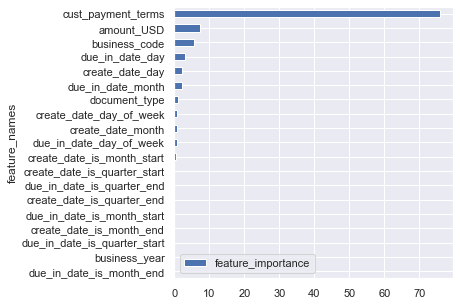

In [152]:
# getting the feature importance of this model manually
feat_imp = pd.DataFrame({'feature_importance': cb.get_feature_importance(pool_train), 
              'feature_names': X_train_cat.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
              
feat_imp[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

In [148]:
# getting regression accuracy scores
rmse = mean_squared_error(y_test_cat, y_pred, squared=False)
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_cat, y_pred)
print("R2: %f" % (r2))

RMSE: 8.903265
R2: 0.320020


Baseline CatBoost Regressor gives us a RMSE of **8.90** with a R2 of **0.32**.

### Random Forests Baseline

RF also doesn't take categorical variables so we use our numerical DF.

In [153]:
# instantiating model
regressor = RandomForestRegressor(n_estimators=100, 
                                  random_state=42,
                                  oob_score = True,
                                  n_jobs = -1,
                                  max_features = "auto", 
                                  min_samples_leaf = 50)


In [154]:
# train
regressor.fit(X_train_num, y_train_num)
# predict
y_pred = regressor.predict(X_test_num)

<AxesSubplot:>

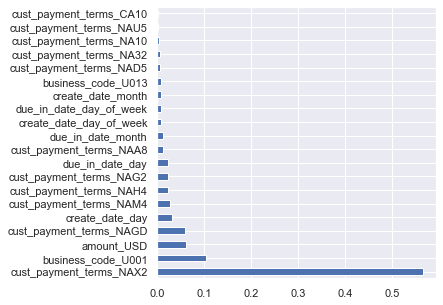

In [157]:
# visualizing Feature Importance
feat_importances = pd.Series(regressor.feature_importances_, index=X_train_num.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [155]:
# getting regression accuracy scores
rmse = np.sqrt(mean_squared_error(y_test_num, y_pred))
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_num, y_pred)
print("R2: %f" % (r2))

RMSE: 8.587226
R2: 0.367438


Baseline Random Forests give us a RMSE of **8.58** with a R2 of **0.36**.

# 6. Hyperparameter Tuning of our Models

We'll be using Optuna to tune the hyperparameters of our Models.

## XGBoost Regressor Tuning

### Conducting Hyperparameter Search

In [158]:
# defining our objective function which will search for the best param in the given set

def objective(trial, X_train_num=X_train_num, X_val_num=X_val_num, y_train_num=y_train_num, y_val_num=y_val_num, X_test_num=X_test_num, y_test_num=y_test_num):
    
    # train-test-val X and Y
    train_x = X_train_num; val_x = X_val_num; train_y = y_train_num; val_y = y_val_num; test_x = X_test_num; test_y = y_test_num
    
    # hyperparameters set
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    # instantiating the model
    model = xgb.XGBRegressor(**param)  
    
    # train
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=False)
    
    # predict
    preds = model.predict(test_x)
    
    # calculate error
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    # return error to be optimized upon
    return rmse

In [196]:
# study will minimize our rmse error in 50 trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-02-15 23:10:01,397] A new study created in memory with name: no-name-15f0c313-bcbc-40fe-b6ad-3707c18ae571
[I 2022-02-15 23:10:27,291] Trial 0 finished with value: 8.621200444945842 and parameters: {'lambda': 2.198606286023888, 'alpha': 0.012429644787737806, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 53}. Best is trial 0 with value: 8.621200444945842.
[I 2022-02-15 23:10:50,888] Trial 1 finished with value: 8.62653718823539 and parameters: {'lambda': 1.1650523131545136, 'alpha': 0.017484293232348052, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 103}. Best is trial 0 with value: 8.621200444945842.
[I 2022-02-15 23:11:10,488] Trial 2 finished with value: 8.701726191777352 and parameters: {'lambda': 0.40892246128928, 'alpha': 6.734002456087952, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth':

Number of finished trials: 50
Best trial: {'lambda': 0.11886199100318691, 'alpha': 0.01847702597712094, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 145}


In [197]:
# log of all trials and param experiments
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,8.621200,2022-02-15 23:10:01.402596,2022-02-15 23:10:27.289006,0 days 00:00:25.886410,0.012430,0.3,2.198606,0.012,9,53,2020,0.5,COMPLETE
1,1,8.626537,2022-02-15 23:10:27.291999,2022-02-15 23:10:50.886694,0 days 00:00:23.594695,0.017484,0.6,1.165052,0.016,15,103,2020,0.7,COMPLETE
2,2,8.701726,2022-02-15 23:10:50.889687,2022-02-15 23:11:10.487057,0 days 00:00:19.597370,6.734002,0.3,0.408922,0.020,20,103,24,0.4,COMPLETE
3,3,8.603800,2022-02-15 23:11:10.490050,2022-02-15 23:11:51.237904,0 days 00:00:40.747854,0.196022,1.0,0.061790,0.012,5,150,48,0.7,COMPLETE
4,4,8.629983,2022-02-15 23:11:51.241893,2022-02-15 23:12:15.434591,0 days 00:00:24.192698,0.239951,0.8,0.271908,0.018,5,224,48,1.0,COMPLETE
5,5,10.105871,2022-02-15 23:12:15.438586,2022-02-15 23:12:37.073504,0 days 00:00:21.634918,0.196466,0.9,0.009946,0.008,7,235,2020,0.4,COMPLETE
6,6,8.599860,2022-02-15 23:12:37.077635,2022-02-15 23:12:53.199807,0 days 00:00:16.122172,0.001653,0.8,0.257981,0.010,7,47,2020,0.5,COMPLETE
7,7,8.597613,2022-02-15 23:12:53.203800,2022-02-15 23:13:26.220363,0 days 00:00:33.016563,0.905121,0.5,4.030167,0.020,20,127,2020,0.8,COMPLETE
8,8,8.638222,2022-02-15 23:13:26.224353,2022-02-15 23:14:06.129195,0 days 00:00:39.904842,0.007867,0.5,0.006800,0.012,7,285,2020,0.7,COMPLETE
9,9,9.422490,2022-02-15 23:14:06.133183,2022-02-15 23:14:23.297579,0 days 00:00:17.164396,1.073667,0.9,0.015566,0.018,7,191,2020,0.4,COMPLETE


In [198]:
# plot_optimization_history: shows the scores from all trials as well as the best score so far at each point
optuna.visualization.plot_optimization_history(study)

In [199]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [200]:
# plot_slice: shows the evolution of the search to see where in the hyperparameter space the search went and which parts of the space were explored more
optuna.visualization.plot_slice(study)

In [201]:
# plot_contour: plots parameter interactions on an interactive chart. We can choose which hyperparameters we would like to explore
optuna.visualization.plot_contour(study, 
                                  params=['alpha',
                                          'max_depth',
                                          'lambda',
                                          'colsample_bytree',
                                          'min_child_weight',
                                          'learning_rate',
                                          'subsample'])

In [202]:
# Visualize hyperparameter importances
optuna.visualization.plot_param_importances(study)

In [203]:
# Visualize empirical distribution function
optuna.visualization.plot_edf(study)

### Building a tuned Model with the best Hyperparameters

In [159]:
# defining our best hyperparams set
Best_trial = {'lambda': 0.11886199100318691, 
              'alpha': 0.01847702597712094, 
              'colsample_bytree': 1.0, 
              'subsample': 0.7, 
              'learning_rate': 0.012, 
              'max_depth': 5, 
              'random_state': 48, 
              'min_child_weight': 145, 
              'n_estimators': 4000}

In [160]:
# setting up the model with the best parameters
model = xgb.XGBRegressor(**Best_trial)
model.fit(X_train_num, y_train_num, eval_set=[(X_val_num, y_val_num)], early_stopping_rounds=100, verbose=False)

# doing 5-fold cross validation
cv = KFold(n_splits=5, random_state=48, shuffle=True)
scores = cross_val_score(model, X_train_num, y_train_num, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
print('Cross Val MSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Cross Val MSE: -91.720 (8.272)


In [161]:
# getting regression accuracy scores

preds = model.predict(X_test_num)

rmse = np.sqrt(mean_squared_error(y_test_num, preds))
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_num, preds)
print("R2: %f" % (r2))

RMSE: 8.596067
R2: 0.366135


A tuned XGBoost Regressor gives us a RMSE of **8.59** with a R2 of **0.36**.

## LightGBM Tuning

### Conducting Hyperparameter Search

In [176]:
# defining our objective function which will search for the best param in the given set

def objective(trial, X_train_cat=X_train_cat, X_val_cat=X_val_cat, y_train_cat=y_train_cat, y_val_cat=y_val_cat, X_test_cat=X_test_cat, y_test_cat=y_test_cat):
    
    train_x = X_train_cat; val_x = X_val_cat; train_y = y_train_cat; val_y = y_val_cat; test_x = X_test_cat; test_y = y_test_cat
    
    param = {
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x, 
              train_y, 
              eval_set=[(val_x,val_y)], 
              categorical_feature = cat_idx_train,
              early_stopping_rounds=100, 
              verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds, squared=False)
    
    return rmse

In [177]:
# study will minimize our rmse error in 50 trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-02-18 17:32:30,505] A new study created in memory with name: no-name-06db8064-46c3-4e72-aff9-72eac8e0c1eb
[I 2022-02-18 17:32:33,091] Trial 0 finished with value: 8.589241812192821 and parameters: {'reg_alpha': 0.41671371263547397, 'reg_lambda': 0.07717271240265336, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 905, 'min_child_samples': 257, 'cat_smooth': 57}. Best is trial 0 with value: 8.589241812192821.
[I 2022-02-18 17:32:39,829] Trial 1 finished with value: 8.691865950635906 and parameters: {'reg_alpha': 0.057448559125752925, 'reg_lambda': 3.534147385123495, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 308, 'min_child_samples': 36, 'cat_smooth': 13}. Best is trial 0 with value: 8.589241812192821.
[I 2022-02-18 17:32:42,226] Trial 2 finished with value: 8.61351874864703 and parameters: {'reg_alpha': 0.059580591070368734, 'reg_lambda': 0.005108000141107204, 'colsample_byt

Number of finished trials: 50
Best trial: {'reg_alpha': 1.1722377783328846, 'reg_lambda': 0.013554452101329849, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 14, 'min_child_samples': 112, 'cat_smooth': 72}


In [178]:
# plot_optimization_history: shows the scores from all trials as well as the best score so far at each point
optuna.visualization.plot_optimization_history(study)

In [179]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [180]:
# plot_slice: shows the evolution of the search to see where in the hyperparameter space the search went and which parts of the space were explored more
optuna.visualization.plot_slice(study)

In [181]:
# Visualize hyperparameter importances
optuna.visualization.plot_param_importances(study)

### Building a tuned Model with the best Hyperparameters

In [182]:
study.best_params

{'reg_alpha': 1.1722377783328846,
 'reg_lambda': 0.013554452101329849,
 'colsample_bytree': 0.4,
 'subsample': 1.0,
 'learning_rate': 0.008,
 'max_depth': 10,
 'num_leaves': 14,
 'min_child_samples': 112,
 'cat_smooth': 72}

In [183]:
# defining our best hyperparams set
Best_trial = {'reg_alpha': 1.1722377783328846, 
              'reg_lambda': 0.013554452101329849, 
              'colsample_bytree': 0.4, 
              'subsample': 1.0, 
              'learning_rate': 0.008, 
              'max_depth': 10, 
              'num_leaves': 14,
              'min_child_samples': 112,
              'cat_smooth': 72,
              'random_state': 42, 
              'metric': 'rmse', 
              'n_estimators': 20000}

In [187]:
# doing 5-fold cross validation
model = lgbm.LGBMRegressor(**Best_trial)
cv = KFold(n_splits=5, random_state=48, shuffle=True)

scores = cross_val_score(model, X_train_num, y_train_num, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
print('Cross Val RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Cross Val RMSE: -9.589 (0.402)


In [189]:
# getting regression accuracy scores
model = lgbm.LGBMRegressor(**Best_trial)
model.fit(X_train_cat, y_train_cat, eval_set=[(X_val_cat, y_val_cat)], categorical_feature = cat_idx_train, early_stopping_rounds=100, verbose=False)
preds = model.predict(X_test_cat)

rmse = np.sqrt(mean_squared_error(y_test_cat, preds))
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_cat, preds)
print("R2: %f" % (r2))

RMSE: 8.506037
R2: 0.379343


A tuned LightGBM Regressor gives us a RMSE of **8.50** with a R2 of **0.37**.

## CatBoost Tuning

### Conducting Hyperparameter Search

In [203]:
# defining our objective function which will search for the best param in the given set

def objective(trial, X_train_cat=X_train_cat, X_val_cat=X_val_cat, y_train_cat=y_train_cat, y_val_cat=y_val_cat, X_test_cat=X_test_cat, y_test_cat=y_test_cat):
    
    train_x = X_train_cat; val_x = X_val_cat; train_y = y_train_cat; val_y = y_val_cat; test_x = X_test_cat; test_y = y_test_cat
    
    param = {
        'n_estimators': 100,
        'random_state': 42,
        'loss_function': 'RMSE',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 1e1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),
    }
    # conditional hyperparameters
    if param['boosting_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['boosting_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    model = CatBoostRegressor(**param) 
    
    pool_train = Pool(train_x, train_y, cat_features=cat_features)
    pool_val = Pool(val_x, val_y, cat_features=cat_features)
    pool_test = Pool(test_x, cat_features=cat_features)
    
    model.fit(pool_train, 
              eval_set=pool_val, 
              early_stopping_rounds=100, 
              verbose=False)
    
    preds = model.predict(pool_test)
    
    rmse = mean_squared_error(test_y, preds, squared=False)
    
    return rmse

In [204]:
# study will minimize our rmse error in 50 trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-02-18 20:17:28,483] A new study created in memory with name: no-name-acd7cc5e-e569-4748-b3a5-9a15e3fa97f6
[I 2022-02-18 20:17:30,741] Trial 0 finished with value: 10.757467575225569 and parameters: {'learning_rate': 0.0022183298286631453, 'l2_leaf_reg': 0.42355816121912837, 'colsample_bylevel': 0.06216015827877316, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 10}. Best is trial 0 with value: 10.757467575225569.
[I 2022-02-18 20:17:34,439] Trial 1 finished with value: 9.381499892393363 and parameters: {'learning_rate': 0.11303965726048704, 'l2_leaf_reg': 0.11156446586346049, 'colsample_bylevel': 0.09058110569302115, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 16, 'one_hot_max_size': 2}. Best is trial 1 with value: 9.381499892393363.
[I 2022-02-18 20:17:36,022] Trial 2 finished with value: 10.720012083985145 and parameters: {'learning_rate': 0.011309583736181851, 'l2_l

Number of finished trials: 50
Best trial: {'learning_rate': 0.11303965726048704, 'l2_leaf_reg': 0.11156446586346049, 'colsample_bylevel': 0.09058110569302115, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 16, 'one_hot_max_size': 2}


In [205]:
# plot_optimization_history: shows the scores from all trials as well as the best score so far at each point
optuna.visualization.plot_optimization_history(study)

In [206]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [207]:
# plot_slice: shows the evolution of the search to see where in the hyperparameter space the search went and which parts of the space were explored more
optuna.visualization.plot_slice(study)

In [208]:
# Visualize hyperparameter importances
optuna.visualization.plot_param_importances(study)

### Building a tuned Model with the best Hyperparameters

In [209]:
study.best_params

{'learning_rate': 0.11303965726048704,
 'l2_leaf_reg': 0.11156446586346049,
 'colsample_bylevel': 0.09058110569302115,
 'depth': 8,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'min_data_in_leaf': 16,
 'one_hot_max_size': 2}

In [210]:
# defining our best hyperparams set
Best_trial = {'learning_rate': 0.11303965726048704, 
              'l2_leaf_reg': 0.11156446586346049, 
              'colsample_bylevel': 0.09058110569302115, 
              'depth': 8, 
              'bootstrap_type': 'Bernoulli', 
              'boosting_type': 'Plain', 
              'one_hot_max_size': 2,
              'min_data_in_leaf': 16,
              'n_estimators': 100,
              'random_state': 42,
              'loss_function': 'RMSE',}

In [212]:
# getting regression accuracy scores
model = CatBoostRegressor(**Best_trial) 
    
pool_train = Pool(X_train_cat, y_train_cat, cat_features=cat_features)
pool_test = Pool(X_test_cat, cat_features=cat_features)

model.fit(pool_train, verbose=False)

preds = model.predict(pool_test)

rmse = mean_squared_error(y_test_cat, preds, squared=False)

rmse = mean_squared_error(y_test_cat, preds, squared=False)
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_cat, preds)
print("R2: %f" % (r2))

RMSE: 9.340787
R2: 0.251547


A tuned CatBoost Regressor gives us a RMSE of **9.34** with a R2 of **0.25**.

## Random Forests Tuning

### Conducting Hyperparameter Search

In [209]:
# defining objective function for hyperparam search

def objective(trial, X_train_num=X_train_num, X_val_num=X_val_num, y_train_num=y_train_num, y_val_num=y_val_num, X_test_num=X_test_num, y_test_num=y_test_num):
    
    train_x = X_train_num; val_x = X_val_num; train_y = y_train_num; val_y = y_val_num; test_x = X_test_num; test_y = y_test_num
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        'max_depth': trial.suggest_int('max_depth', 10, 110, log=True),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    for step in range(100):
        model = RandomForestRegressor(**param)
        model.fit(train_x, train_y)
        r2_score = model.score(val_x, val_y)
        trial.report(r2_score, step)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        return r2_score

In [210]:
# study to maximize the r2 score in 100 trials
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-02-15 23:48:54,906] A new study created in memory with name: no-name-22618bf3-47b1-498e-a633-04a0d9f3a5e1
[I 2022-02-15 23:49:47,824] Trial 0 finished with value: 0.3283238149665715 and parameters: {'n_estimators': 720, 'max_features': 'sqrt', 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.3283238149665715.
[I 2022-02-15 23:53:32,392] Trial 1 finished with value: 0.1681066019955828 and parameters: {'n_estimators': 1067, 'max_features': 'auto', 'max_depth': 83, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.3283238149665715.
[I 2022-02-15 23:55:36,399] Trial 2 finished with value: 0.32653758018014745 and parameters: {'n_estimators': 1935, 'max_features': 'sqrt', 'max_depth': 66, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.3283238149665715.
[I 2022-02-15 23:56:59,384] Trial 3 finished with value: -0.196679732

In [211]:
# Calculating the pruned and completed trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

In [212]:
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

  Number of finished trials:  100
  Number of pruned trials:  45
  Number of complete trials:  55


In [213]:
# Visualize the optimization history.
optuna.visualization.plot_optimization_history(study)

In [214]:
# Visualize the parallel coordinate
optuna.visualization.plot_parallel_coordinate(study, params=[
    'n_estimators', 
    'max_features',
    'max_depth',
    'min_samples_split',
    'min_samples_leaf',
    'bootstrap'
    ])

In [215]:
# Visualize the slice plot
optuna.visualization.plot_slice(study, params=[
    'n_estimators', 
    'max_features',
    'max_depth',
    'min_samples_split',
    'min_samples_leaf',
    'bootstrap'
    ])

### Building a tuned Model with the best Hyperparameters

In [162]:
Best_trial = {'n_estimators': 811, 
              'max_features': 'sqrt', 
              'max_depth': 31, 
              'min_samples_split': 10, 
              'min_samples_leaf': 4, 
              'bootstrap': True,
              'random_state': 42}

In [163]:
model = RandomForestRegressor(**Best_trial)
model.fit(X_train_num, y_train_num)

RandomForestRegressor(max_depth=31, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=811, random_state=42)

In [164]:
# getting regression accuracy scores

y_pred = model.predict(X_test_num)

rmse = np.sqrt(mean_squared_error(y_test_num, y_pred))
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test_num, y_pred)
print("R2: %f" % (r2))

RMSE: 8.694975
R2: 0.351464


A tuned Random Forests gives us a RMSE of **8.69** with a R2 of **0.35**.

# 7. Conclusion

After all our experiments above, we can conclude that `LightGBM` gives us the best performance after hyperparameter tuning with a **8.5 RMSE** and a **0.37 R2_Score**.